In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import xgboost as xgb
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

import os
from datetime import datetime
from github import Github
from dotenv import load_dotenv
from IPython.display import clear_output

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)
plt.style.use('ggplot')

load_dotenv()
GITHUB_API_KEY = os.environ['GITHUB_API_KEY']

In [ ]:
g = Github(GITHUB_API_KEY)
repo = g.get_user().get_repo('Estate-Prague')
contents = repo.get_contents("data-rental")

df_concated = pd.read_csv(contents[0].download_url)

for file in contents:
    clear_output(wait=True)
    print(f'Processing file: {file.name}')
    url = file.download_url
    df_single = pd.read_csv(url)
    df_concated = pd.concat([df_concated,df_single],axis=0,ignore_index=True)

df_unique = df_concated.drop_duplicates(subset=['Listing ID','Floor Space'], keep='first')

In [11]:
# df_unique.to_csv('df_unique.csv')
df_unique = pd.read_csv('df_unique.csv')

In [14]:
df = pd.read_csv(contents[0].download_url)

In [15]:
def missing_data(df):
    return 100*df.isnull().sum()/len(df)

def droping_data(df):
    
    df = df.drop('Listing ID',axis=1) 
    df = df.drop('New building',axis=1)
    df = df.drop('Front garden',axis=1)
    df = df.drop('Developer name',axis=1)
    df = df.drop('Project name',axis=1)
    df = df.drop('Kód jednotky',axis=1)
    df = df.drop('Administration fee',axis=1)
    df = df.drop('Ownership Type',axis=1)
    df = df.drop('Refundable security deposit',axis=1)
    df = df.drop('Available from',axis=1)
    df = df.drop('Playground',axis=1)
    df = df.drop('Post office',axis=1)
    df = df.drop('Bank',axis=1)
    df = df.drop('Pharmacy',axis=1)
    df = df.dropna(axis=0,subset=['Floor Space'])
    
    return df

def district_extract(string):
    return string.split('Prague - ')[1]

def rare_district_renaming(district):
    if district not in df['District'].value_counts()[:25].index:
        return 'Other'
    else:
        return district

def feature_engineering(df):
    
    df['Price'] = pd.to_numeric(df['Price'].str.replace('CZK ','').str.replace(',',''))
    df['Fees'] = pd.to_numeric(df['Fees'].str.replace('CZK ','').str.replace(',',''))
    df['Floor Space'] = pd.to_numeric(df['Floor Space'].str.replace(',','').str.replace(' m²',''))
    df['District'] = df['District'].apply(district_extract)
    df['District'] = df['District'].apply(rare_district_renaming)
    
    if df['Public transport stop'].dtype == 'O':
        df['Public transport stop'] = pd.to_numeric(df['Public transport stop'].str.replace(',',''))
    if df['Shop'].dtype == 'O':
        df['Shop'] = pd.to_numeric(df['Shop'].str.replace(',',''))
    if df['Restaurant'].dtype == 'O':
        df['Restaurant'] = pd.to_numeric(df['Restaurant'].str.replace(',',''))
    if df['School'].dtype == 'O':
        df['School'] = pd.to_numeric(df['School'].str.replace(',',''))
    if df['Kindergarten'].dtype == 'O':
        df['Kindergarten'] = pd.to_numeric(df['Kindergarten'].str.replace(',',''))
    if df['Sports field'].dtype == 'O':
        df['Sports field'] = pd.to_numeric(df['Sports field'].str.replace(',',''))
    
    return df

def filtering_outliers(df):
    
    df = df[df['Floor Space']>10]
    df = df[df['Floor Space']<125]
    df = df[df['Price']>3000]
    df = df[df['Price']<30000]
    df = df[df['Fees']<10000]
    df.loc[df['Fees']<400,'Fees'] = np.nan
    
    return df

def fixing_fees(df):
    
    df['ratio'] = df['Price']/df['Fees']
    df.loc[(df['ratio'].between(2.95,3.05)) & (df['Price']>10000),'Fees'] = np.nan
    df = df.drop('ratio',axis=1)
    fees_df = df[['Floor Space','Fees']]
    fees_df = fees_df.dropna()
    fees_coeff = np.polyfit(fees_df['Floor Space'],fees_df['Fees'],1)
    df['Fees'] = df['Fees'].fillna(fees_coeff[0]*df['Floor Space'] + fees_coeff[1])
    
    return df

def total_cost(df):
    
    df['Total price'] = df['Price']+df['Fees']
    df = df.drop('Price',axis=1) 
    df = df.drop('Fees',axis=1) 
    
    return df

def mapping_data(df):
    
    df['Layout'] = df['Layout'].map({
                                        'Small studio':0.5, 
                                        'Studio':0.75,
                                        '1 bedroom with open-plan kitchen':1.5,
                                        '1 bedroom':1,
                                        '2 bedroom with open-plan kitchen':2.5,
                                        '2 bedroom':2,
                                        '3 bedroom with open-plan kitchen':3.5,
                                        '3 bedroom':3,
                                        '4 bedroom with open-plan kitchen':4.5,
                                        '4 bedroom':4,
                                        '5 bedroom with open-plan kitchen':5.5,   
                                        '5 bedroom':5,
                                        '6 bedroom with open-plan kitchen':6.5,
                                        '6 bedroom':6
                                                                                })
    
    
    df['PENB'] = df['PENB'].map({'G':7,'F':6,'E':5,'D':4,'C':3,'B':2,'A':1})
    
    df['Balcony'] = df['Balcony'].map({'Yes':1,'No':0})
    df['Terrace'] = df['Terrace'].map({'Yes':1,'No':0})
    df['Cellar'] = df['Cellar'].map({'Yes':1,'No':0})
    df['Loggia'] = df['Loggia'].map({'Yes':1,'No':0})
    df['Parking'] = df['Parking'].map({'Yes':1,'No':0})
    df['Lift'] = df['Lift'].map({'Yes':1,'No':0})
    df['Garage'] = df['Garage'].map({'Yes':1,'No':0})
    
    return df

def replacing_categories(df):
    
    df['Condition'] = df['Condition'].replace('In need of repair',np.nan)
    df['Condition'] = df['Condition'].replace('Development project','New build')
    df['Building Type'] = df['Building Type'].replace('Wooden building',np.nan)
    df['Total number of floors'] = df['Total number of floors'].replace('Raised ground floor','Ground floor')
    df['Heating'] = df['Heating'].replace('Geothermal heat pump',np.nan)
    df.loc[df['Floor']>10,'Floor'] = 10
    df['Age'] = df['Age'].replace('over 50 years years','over 30 years years')
    df['Age'] = df['Age'].replace('30 to 50 years years','over 30 years years')
    df['Renovation'] = df['Renovation'].replace('Exterior',np.nan)
    df['Renovation'] = df['Renovation'].replace('Bathroom unit',np.nan)
    
    return df

def missing_values(df):
    
    df['Design'] = df['Design'].fillna('Standard materials and solutions')
    df['Floor'] = df['Floor'].fillna(1)
    df['Public transport stop'] = df['Public transport stop'].fillna(df['Public transport stop'].median())
    df['Shop'] = df['Shop'].fillna(df['Shop'].median())
    df['Restaurant'] = df['Restaurant'].fillna(df['Restaurant'].median())
    df['School'] = df['School'].fillna(df['School'].median())
    df['Kindergarten'] = df['Kindergarten'].fillna(df['Kindergarten'].median())
    df['Sports field'] = df['Sports field'].fillna(df['Sports field'].median())
    df['PENB'] = df['PENB'].fillna(np.round(df.groupby('Building Type')['PENB'].transform('mean'),0))
    df['PENB'] = df['PENB'].fillna(5)
        
    return df

In [16]:
def preprocessing(df):
    df = droping_data(df)
    df = feature_engineering(df)
    df = filtering_outliers(df)
    df = fixing_fees(df)
    df = total_cost(df)
    df = mapping_data(df)
    df = replacing_categories(df)
    df = missing_values(df)
    return df

In [17]:
df = preprocessing(df)
df_unique = preprocessing(df_unique)

In [5]:
y = df['Total price']
X = df.drop('Total price',axis=1)

In [6]:
X = pd.get_dummies(X,drop_first=False)
X.columns = X.columns.str.replace(' ','_')

In [7]:

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=101,shuffle=True)

## XGBoost

In [1]:
from shaphypetune import BoostSearch, BoostRFE, BoostRFA, BoostBoruta

In [23]:
grid_paramters = {
                   'n_estimators': randint(10,250),
                   'eta': uniform(0.001,0.3),
                   'gamma': uniform(0.01,5),
                   'max_depth':[1,2,3,4,5,6],
                   'subsample': uniform(0.01,0.99),
                   'colsample_bytree': uniform(0.01,0.99),
                   'colsample_bylevel': uniform(0.01,0.99),
                   'min_child_weight': uniform(0.1,10),
                   'reg_lambda': uniform(0,200),
                   'reg_alpha': uniform(1,750)
                 }

In [49]:
grid_paramters = {
                   'eta': uniform(0.001,0.3),
                   'gamma': uniform(0.01,5),
                   'max_depth':[1,2,3,4,5,6],
                   'subsample': uniform(0.01,0.99),
                   'colsample_bytree': uniform(0.01,0.99),
                   'colsample_bylevel': uniform(0.01,0.99),
                   'min_child_weight': uniform(0.1,10),
                  #  'reg_lambda': uniform(0,200),
                  #  'reg_alpha': uniform(1,750)
                 }

xgb9 = xgb.XGBRegressor(n_estimators=250)
# model = BoostSearch(xgb9, param_grid=grid_paramters,n_iter=50,n_jobs=1)
# model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=5, verbose=0)

In [50]:
model = BoostRFA(
    xgb9, param_grid=grid_paramters, min_features_to_select=1, step=1,
    n_iter=8, sampling_seed=0,
    importance_type='shap_importances', train_importance=False
)

model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=6, verbose=0)


8 trials detected for ('eta', 'gamma', 'max_depth', 'subsample', 'colsample_bytree', 'colsample_bylevel', 'min_child_weight')

trial: 0001 ### iterations: 00035 ### eval_score: 2841.53076
trial: 0002 ### iterations: 00054 ### eval_score: 2896.3977
trial: 0003 ### iterations: 00249 ### eval_score: 3265.49658
trial: 0004 ### iterations: 00094 ### eval_score: 3037.70483
trial: 0005 ### iterations: 00111 ### eval_score: 2971.93701
trial: 0006 ### iterations: 00032 ### eval_score: 2662.6311
trial: 0007 ### iterations: 00165 ### eval_score: 2847.49658
trial: 0008 ### iterations: 00034 ### eval_score: 2660.83716


BoostRFA(estimator=XGBRegressor(base_score=None, booster=None,
                                colsample_bylevel=None, colsample_bynode=None,
                                colsample_bytree=None, enable_categorical=False,
                                gamma=None, gpu_id=None, importance_type=None,
                                interaction_constraints=None,
                                learning_rate=None, max_delta_step=None,
                                max_depth=None, min_child_weight=None,
                                missing=nan, monotone_constraints=None,
                                n_estimato...
                     'eta': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000210F30205E0>,
                     'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000210F0BEEE80>,
                     'max_depth': [1, 2, 3, 4, 5, 6],
                     'min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000210F2F7

In [51]:
model.n_features_

52

In [52]:
model.transform(X_test)

,Latitude,Longitude,Layout,Floor_Space,Floor,Balcony,Terrace,Cellar,Loggia,Parking,Lift,Garage,Public_transport_stop,Shop,Restaurant,School,Kindergarten,Sports_field,PENB,District_Braník,District_Dejvice,District_Holešovice,District_Karlín,District_Libeň,District_Nové_Město,District_Other,District_Podolí,District_Smíchov,District_Stodůlky,District_Vinohrady,District_Vršovice,District_Záběhlice,District_Žižkov,Furnishing_and_Fittings_Furnished,Furnishing_and_Fittings_Partially_furnished,Furnishing_and_Fittings_Unfurnished,Condition_Excellent,Condition_Good,Condition_New_build,Building_Type_Brick_building,Building_Type_Prefab_concrete_building,Design_Premium_materials_and_solutions,Design_Standard_materials_and_solutions,Heating_District_heating,Heating_Gas_boiler,Heating_Other,Total_number_of_floors_Ground_floor,Total_number_of_floors_Middle_floor,Total_number_of_floors_Top_floor,Age_1_to_10_years_years,Age_over_30_years_years,Renovation_Interior
410,50.078470,14.445630,1.50,55,-1.0,0,0,0,0,0,0,0,391.0,26.0,37.0,315.0,78.0,245.0,7.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0
494,50.035350,14.422130,0.75,31,4.0,0,0,1,0,0,0,0,49.0,460.0,539.0,739.0,1039.0,255.0,4.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0
914,50.128049,14.502019,0.50,32,3.0,0,0,0,0,0,1,0,289.0,97.0,677.0,423.0,583.0,214.0,7.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
823,50.108100,14.445631,1.50,40,2.0,1,0,1,0,1,0,0,115.0,185.0,82.0,276.0,938.0,453.0,7.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0
1225,50.047190,14.302850,1.50,65,7.0,0,1,0,0,0,1,0,285.0,44.0,1059.0,654.0,815.0,110.0,7.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,50.056361,14.432318,0.75,45,3.0,1,0,0,0,0,0,0,162.0,175.0,207.0,728.0,454.0,195.0,7.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0
291,50.100222,14.437097,0.75,30,7.0,0,1,0,0,0,1,0,57.0,128.0,249.0,241.0,1276.0,671.0,5.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
815,50.101752,14.452948,1.50,48,5.0,1,0,0,0,0,1,0,188.0,95.0,25.0,407.0,369.0,113.0,2.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0
753,50.075164,14.447586,1.00,47,5.0,0,0,0,0,0,1,0,181.0,139.0,146.0,514.0,107.0,447.0,7.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0


In [53]:
model.score(X_test,y_test)

0.683947764073124

In [9]:
xgb1 = xgb.XGBRegressor()
xgb_grid = RandomizedSearchCV(
                                estimator = xgb1,
                                param_distributions = grid_paramters,
                                scoring = 'neg_mean_absolute_error',
                                n_iter = 2500,
                                cv = 6,
                                verbose=1,
                                n_jobs = -1
                              )

xgb_grid.fit(X_train,y_train)

Fitting 6 folds for each of 2500 candidates, totalling 15000 fits


KeyboardInterrupt: 

In [ ]:
y_pred_train = xgb_grid.predict(X_train)
y_pred = xgb_grid.predict(X_test)

MAE = mean_absolute_error(y_test,y_pred)
ERR = np.mean(np.abs(y_test-y_pred)*100/y_test)
print(f'Mean error test: {np.round(MAE)} CZK')
print(f'Mean error test: {np.round(ERR)} %\n')

MAE2 = mean_absolute_error(y_train,y_pred_train)
ERR2 = np.mean(np.abs(y_train-y_pred_train)*100/y_train)
print(f'Mean error train: {np.round(MAE2)} CZK')
print(f'Mean error train: {np.round(ERR2)} %')

Mean error test: 1964.0 CZK
Mean error test: 11.0 %

Mean error train: 1078.0 CZK
Mean error train: 6.0 %


## XGBoost selected columns

In [1]:
columns_to_keep = ['Latitude','Longitude','Layout','Floor Space','Furnishing and Fittings','Terrace','Lift','Garage','Condition','Building Type','Design','Age']
X_selected = df[columns_to_keep]
X_selected = pd.get_dummies(X_selected,drop_first=False)
X_selected.columns = X_selected.columns.str.replace(' ','_')
X_selected_train, X_selected_test, y2_train, y2_test = train_test_split(X_selected,y,test_size=0.25,random_state=101,shuffle=True)

NameError: name 'df' is not defined

In [53]:
grid_paramters = {'n_estimators': randint(10,250),
                  'eta': uniform(0.001,0.3),
                  'gamma': uniform(0.01,5),
                  'max_depth':[1,2,3,4,5,6],
                  'subsample': uniform(0.01,0.99),
                  'colsample_bytree': uniform(0.01,0.99),
                  'colsample_bylevel': uniform(0.01,0.99),
                  'min_child_weight': uniform(0.1,10),
                  'reg_lambda': uniform(0,200),
                  'reg_alpha': uniform(1,750)}

In [56]:
xgb1 = xgb.XGBRegressor()
xgb_grid = RandomizedSearchCV(estimator = xgb1,
                              param_distributions = grid_paramters,
                              scoring = 'neg_mean_absolute_error',
                              n_iter = 100,
                              cv = 6,
                              verbose=1,
                              n_jobs = -1)

xgb_grid.fit(X_selected_train,y2_train)

Fitting 6 folds for each of 100 candidates, totalling 600 fits


RandomizedSearchCV(cv=6,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=...
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000245071D16D0>,
                                        'reg_alpha': <scipy

In [57]:
y2_pred_train = xgb_grid.predict(X_selected_train)
y2_pred = xgb_grid.predict(X_selected_test)

MAE = mean_absolute_error(y2_test,y2_pred)
ERR = np.mean(np.abs(y2_test-y2_pred)*100/y2_test)
print(f'Mean error test: {np.round(MAE)} CZK')
print(f'Mean error test: {np.round(ERR)} %\n')

MAE2 = mean_absolute_error(y2_train,y2_pred_train)
ERR2 = np.mean(np.abs(y2_train-y2_pred_train)*100/y2_train)
print(f'Mean error train: {np.round(MAE2)} CZK')
print(f'Mean error train: {np.round(ERR2)} %')

Mean error test: 1860.0 CZK
Mean error test: 11.0 %

Mean error train: 1376.0 CZK
Mean error train: 8.0 %


In [ ]:
best_parameters = xgb_grid.best_params_
best_parameters

{'colsample_bylevel': 0.34594771200021085,
 'colsample_bytree': 0.9932439221172781,
 'eta': 0.18314459151461857,
 'gamma': 1.3940712351511493,
 'max_depth': 6,
 'min_child_weight': 3.0493140575086977,
 'n_estimators': 247,
 'reg_alpha': 479.5031703439803,
 'reg_lambda': 180.95222684767313,
 'subsample': 0.6262971763538391}

In [ ]:
xgb2 = xgb.XGBRegressor(**xgb_grid.best_params_)
xgb2.fit(X_selected,y)

score = np.mean(-cross_val_score(xgb2,X_selected,y,cv=KFold(10,shuffle=True),scoring='neg_mean_absolute_error'))
score = np.round(score,0)

print('Cross validation score:')
print(f'{score} CZK')

Cross validation score:
2028.0 CZK


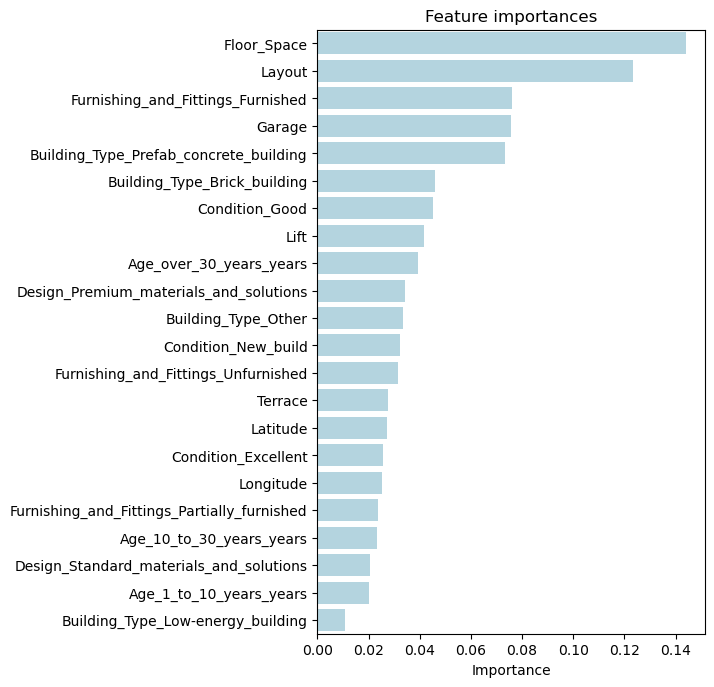

In [ ]:
feat_import = xgb2.feature_importances_
imp_feats = pd.DataFrame(index=X_selected.columns,data=feat_import,columns=['Importance'])
imp_feats = imp_feats[imp_feats['Importance'] > 0.005]
imp_feats = imp_feats.sort_values("Importance",ascending=False)
plt.figure(figsize=(5,8),dpi=100)
sns.barplot(data=imp_feats,y=imp_feats.index,x='Importance',color='lightblue');
plt.title('Feature importances');

In [24]:
columns_to_keep = ['Latitude','Longitude','Layout','Floor Space','Furnishing and Fittings','Terrace','Lift','Garage','Condition','Building Type','Design','Age']
X_sample = df_unique[columns_to_keep]
X_sample = pd.get_dummies(X_sample,drop_first=False)
X_sample.columns = X_sample.columns.str.replace(' ','_')

In [25]:
g = Github(GITHUB_API_KEY)
repo = g.get_user().get_repo('Estate-Prague')
contents = repo.get_contents("data-rental")

xs=[]
ys=[]

for file in contents:
    clear_output(wait=True)
    print(f'Processing file: {file.name}')
    url = file.download_url
    df = pd.read_csv(url)
    df = preprocessing(df)
    y = df['Total price']

    columns_to_keep = ['Latitude','Longitude','Layout','Floor Space','Furnishing and Fittings','Terrace','Lift','Garage','Condition','Building Type','Design','Age']
    X = df[columns_to_keep]
    X = pd.get_dummies(X,drop_first=False)
    X.columns = X.columns.str.replace(' ','_')

    xgb3 = xgb.XGBRegressor(colsample_bylevel=0.35,
                            colsample_bytree=1,
                            eta=0.18,
                            gamma=1.4,
                            max_depth=6,
                            min_child_weight=3,
                            n_estimators=250,
                            reg_alpha=500,
                            reg_lambda=180,
                            subsample=0.6)
    xgb3.fit(X,y)
    y_sample_predition = xgb3.predict(X_sample)
    ys.append(y_sample_predition)
    xs.append(datetime.strptime(file.name, 'Prague-%Y-%m-%d.csv'))

Processing file: Prague-2022-04-02.csv


In [26]:
price_change = []
for ys_i in ys:
    delta = ((ys_i-ys[0])/ys[0]).mean()*100
    price_change.append(delta)

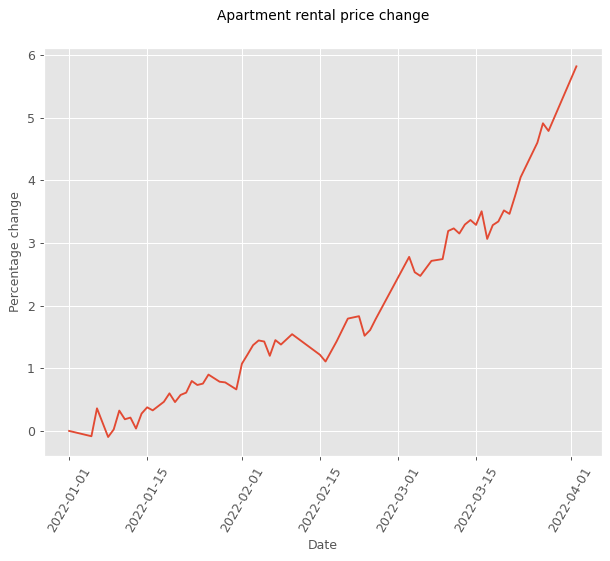

In [30]:
plt.figure(figsize=(8,6),dpi=90)
sns.lineplot(x=xs,y=price_change)
plt.xlabel("Date", fontsize= 10)
plt.ylabel("Percentage change", fontsize= 10)
plt.title("Apartment rental price change", fontsize= 11, y=1.05)
plt.xticks(rotation=60);